# This code file is the final implementation of a toy model for speaker diarization involving 2 person spekaing (Student and Professor) in different intervals of time.

## Relevent Imports

In [65]:
import glob
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Helper Functions

In [68]:
def chunker(y, sr, chunk=1.0):
    """
    Splits a raw audio signal 'y' into consecutive chunks 
    of length 'chunk' seconds.
    """
    chunk_len = int(sr * chunk)
    total_samples = len(y)
    chunks = []
    for start in range(0, total_samples, chunk_len):
        end = start + chunk_len
        if end <= total_samples:
            chunks.append(y[start:end])
    return chunks

def features(y_chunk, sr=16000, n_mfcc=13):
    """
    Extracts MFCC + pitch-based features from a single chunk of audio 'y_chunk'.
    We do a simple summary (mean/std) for demonstration.
    """
    # Compute MFCC
    mfcc = librosa.feature.mfcc(y=y_chunk, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std  = np.std(mfcc, axis=1)
    
    # Compute pitch
    stft = np.abs(librosa.stft(y_chunk))
    pitches, mags = librosa.piptrack(S=stft, sr=sr)
    
    pitch_vals = []
    for frame_idx in range(pitches.shape[1]):
        idx = mags[:, frame_idx].argmax()
        pitch_vals.append(pitches[idx, frame_idx])
    pitch_vals = np.array(pitch_vals)
    
    pitch_mean = np.mean(pitch_vals) if len(pitch_vals) > 0 else 0.0
    pitch_std  = np.std(pitch_vals)  if len(pitch_vals) > 0 else 0.0
    
    # Combine them all
    feat_vector = np.concatenate([mfcc_mean, mfcc_std, [pitch_mean, pitch_std]])
    return feat_vector

## Loading data to train the model, Remember labels: (0 => Student, 1 => Professor)

In [71]:
student_files = glob.glob("dataset/train/student/*.wav")
prof_files    = glob.glob("dataset/train/professor/*.wav")

X = []
y = [] 

# Parameters
SR = 16000      # freq
chunk = 1.0     # chunk size for the clips

# loading student files
for path in student_files:
    y_full, sr = librosa.load(path, sr=SR)
    chunks = chunker(y_full, sr, chunk)
    
    for c in chunks:
        feats = features(c, sr=sr)
        X.append(feats)
        y.append(0)  # label = Student

# laoding professor files
for path in prof_files:
    y_full, sr = librosa.load(path, sr=SR)
    chunks = chunker(y_full, sr, chunk)
    
    for c in chunks:
        feats = features(c, sr=sr)
        X.append(feats)
        y.append(1)  # label = Professor

X = np.array(X)
y = np.array(y)

print("Total training samples (chunks):", len(X))
print("Feature vector shape per chunk:", X.shape[1:])

Total training samples (chunks): 139
Feature vector shape per chunk: (28,)


## Splitting in test and training data

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = MLPClassifier(
    hidden_layer_sizes=(128,),
    max_iter=500,
    random_state=42
)
clf.fit(X_train, y_train)

y_pred_test = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred_test)
print("Test accuracy on held-out training data:", acc)

Test accuracy on held-out training data: 0.9642857142857143


## Loading the testing audio

In [77]:
test_audio_path = "dataset/test/test.wav"
conv_y, conv_sr = librosa.load(test_audio_path, sr=SR)

conv_chunks = chunker(conv_y, conv_sr, chunk)

ground_truth_labels = [
    1, 1, 1, 1, 1,
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    1, 1, 1, 1, 
    0, 0, 0, 0, 0, 0, 0, 0 
]

y_pred_conv = []
for i, c in enumerate(conv_chunks):
    feats = features(c, sr=conv_sr).reshape(1, -1)
    pred_label = clf.predict(feats)[0]  # 0 => Student, 1 => Prof
    y_pred_conv.append(pred_label)

y_pred_conv = np.array(y_pred_conv)

### Audio Waveform

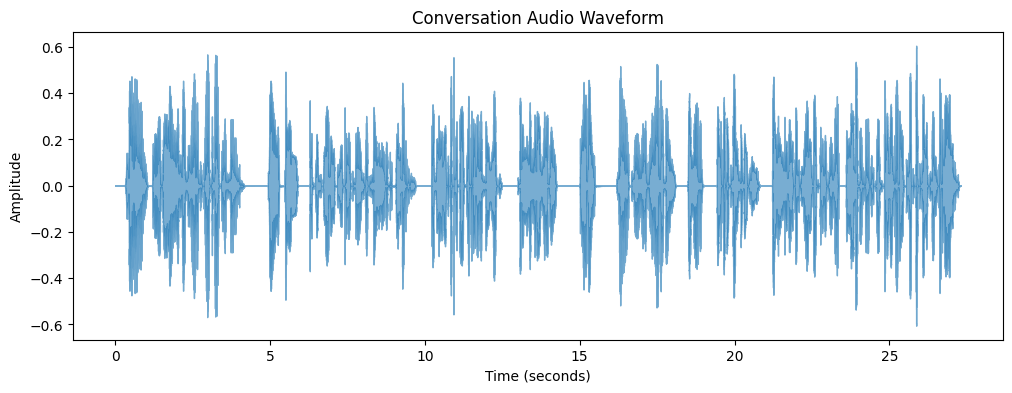

In [80]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(conv_y, sr=conv_sr, alpha=0.6)
plt.title("Conversation Audio Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

In [82]:
print("Number of chunks:", len(conv_chunks))

Number of chunks: 27


In [84]:
print("Number of ground truth labels:", len(ground_truth_labels))
assert len(conv_chunks) == len(ground_truth_labels), \
    "Mismatch between chunk count and ground-truth label count!"

Number of ground truth labels: 27


## Evaluation of the model against ground truth

In [87]:
print("\n--- Chunk-Level Predictions for 'test.wav' ---")
for i in range(len(conv_chunks)):
    start_t = i * chunk
    end_t = (i + 1) * chunk
    
    true_label = ground_truth_labels[i]
    pred_label = y_pred_conv[i]
    
    true_speaker = "Student" if true_label == 0 else "Professor"
    pred_speaker = "Student" if pred_label == 0 else "Professor"
    
    print(f"{start_t:.2f}s - {end_t:.2f}s | "
          f"GROUND TRUTH: {true_speaker} | "
          f"PREDICTION: {pred_speaker}")

# ---- (b) Confusion Matrix & Classification Report
cm = confusion_matrix(ground_truth_labels, y_pred_conv)
print("\nConfusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(
    ground_truth_labels,
    y_pred_conv,
    target_names=["Student", "Professor"]
))


--- Chunk-Level Predictions for 'test.wav' ---
0.00s - 1.00s | GROUND TRUTH: Professor | PREDICTION: Professor
1.00s - 2.00s | GROUND TRUTH: Professor | PREDICTION: Professor
2.00s - 3.00s | GROUND TRUTH: Professor | PREDICTION: Professor
3.00s - 4.00s | GROUND TRUTH: Professor | PREDICTION: Professor
4.00s - 5.00s | GROUND TRUTH: Professor | PREDICTION: Student
5.00s - 6.00s | GROUND TRUTH: Student | PREDICTION: Student
6.00s - 7.00s | GROUND TRUTH: Student | PREDICTION: Student
7.00s - 8.00s | GROUND TRUTH: Student | PREDICTION: Student
8.00s - 9.00s | GROUND TRUTH: Student | PREDICTION: Student
9.00s - 10.00s | GROUND TRUTH: Student | PREDICTION: Student
10.00s - 11.00s | GROUND TRUTH: Student | PREDICTION: Student
11.00s - 12.00s | GROUND TRUTH: Student | PREDICTION: Student
12.00s - 13.00s | GROUND TRUTH: Student | PREDICTION: Student
13.00s - 14.00s | GROUND TRUTH: Student | PREDICTION: Student
14.00s - 15.00s | GROUND TRUTH: Student | PREDICTION: Student
15.00s - 16.00s | GROUN

## Confusion Matrix

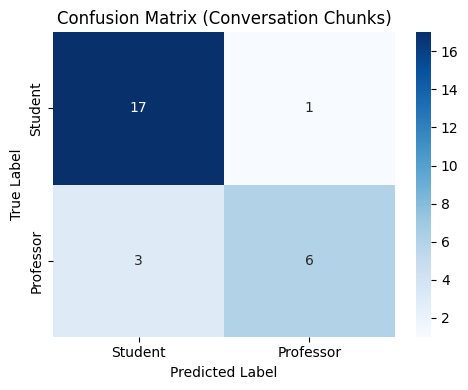

In [90]:
plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True, cmap="Blues",
    xticklabels=["Student", "Professor"],
    yticklabels=["Student", "Professor"],
    fmt="d"
)
plt.title("Confusion Matrix (Conversation Chunks)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()